In [22]:
import warnings
warnings.filterwarnings("ignore")

from util import get_num_lines, get_pos2idx_idx2pos, index_sequence, get_vocab, embed_indexed_sequence, \
    get_word2idx_idx2word, get_embedding_matrix, write_predictions, get_performance_VUAverb_val
from util import TextDatasetWithGloveElmoSuffix as TextDataset
from util import evaluate
from model import RNNSequenceModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm import tqdm
import csv
import h5py
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [23]:
print("PyTorch version:")
print(torch.__version__)
#print("GPU Detected:")
#print(torch.cuda.is_available())
using_GPU = False

PyTorch version:
0.4.1


## 1. Data pre-processing

Читаем датасет как list, каждый элемент содержит 3:
   * предложение: строка
   * индекс рассматриваемого слова
   * лэйбл: 1 или 0

In [76]:
raw_mohx = []

#with open('../data/MOH-X/MOH-X_formatted_svo_cleaned.csv') as f:
#with open('../data/агония.csv', encoding='CP1251') as f:
with open('../data/алтарь.csv', encoding='CP1251') as f:
#with open('../data/master_marga.csv') as f:
    # arg1  	arg2	verb	sentence	verb_idx	label
    lines = csv.reader(f)
    next(lines)
    for line in lines:
        sentence = line[3]
        label_seq = [0] * len(sentence.split())
        pos_seq = [0] * len(label_seq)
        verb_idx = int(line[4])
        verb_label = int(line[5])
        label_seq[verb_idx] = verb_label
        pos_seq[verb_idx] = 1   # idx2pos = {0: 'words that are not focus verbs', 1: 'focus verb'}
        raw_mohx.append([sentence.strip(), label_seq, pos_seq])


print('dataset division: ', len(raw_mohx))

dataset division:  2368


## 2. Data preparation

Получаем словарь и эмбеддинги (использовался glove для английского и https://rusvectores.org/ru/about/ для русского)

In [77]:
# vocab is a set of words
vocab = get_vocab(raw_mohx)
# two dictionaries. <PAD>: 0, <UNK>: 1
word2idx, idx2word = get_word2idx_idx2word(vocab)
# glove_embeddings a nn.Embeddings
glove_embeddings = get_embedding_matrix(word2idx, idx2word, normalization=False)
# elmo_embeddings
# set elmos_mohx=None to exclude elmo vectors. Also need to change the embedding_dim in later model initialization
#elmos_mohx = h5py.File('../elmo/MOH-X_cleaned.hdf5', 'r')
elmos_mohx=None

random.seed(0)
random.shuffle(raw_mohx)

# second argument is the post sequence, which we don't need
embedded_mohx = [[embed_indexed_sequence(example[0], example[2], word2idx,
                                      glove_embeddings, elmos_mohx, None),
                       example[2], example[1]]
                      for example in raw_mohx]

vocab size:  33607


100%|██████████| 189194/189194 [00:08<00:00, 21500.17it/s]


Number of pre-trained word vectors loaded:  7072
Embeddings mean:  0.006742602214217186
Embeddings stdev:  0.6920899748802185


10-фолдная кросс-валидация:

In [78]:
# separate the embedded_sentences and labels into 2 list, in order to pass into the TextDataset as argument
sentences = [example[0] for example in embedded_mohx]
poss = [example[1] for example in embedded_mohx]
labels = [example[2] for example in embedded_mohx]
# ten_folds is a list of 10 tuples, each tuple is (list_of_embedded_sentences, list_of_corresponding_labels)
ten_folds = []
fold_size = int(798 / 10)
for i in range(10):
    ten_folds.append((sentences[i * fold_size:(i + 1) * fold_size],
                      poss[i * fold_size:(i + 1) * fold_size],
                      labels[i * fold_size:(i + 1) * fold_size]))

idx2pos = {0: 'words that are not focus verbs', 1: 'focus verb'}

optimal_f1s = []
optimal_ps = []
optimal_rs = []
optimal_accs = []
predictions_all = []
for i in range(10):
    '''
    2. 3
    set up Dataloader for batching
    '''
    training_sentences = []
    training_labels = []
    training_poss = []
    for j in range(10):
        if j != i:
            training_sentences.extend(ten_folds[j][0])
            training_poss.extend(ten_folds[j][1])
            training_labels.extend(ten_folds[j][2])
    training_dataset_mohx = TextDataset(training_sentences, training_poss, training_labels)
    val_dataset_mohx = TextDataset(ten_folds[i][0], ten_folds[i][1], ten_folds[i][2])
    #print(len(val_dataset_mohx))
    # Data-related hyperparameters
    batch_size = 10
    # Set up a DataLoader for the training, validation, and test dataset
    train_dataloader_mohx = DataLoader(dataset=training_dataset_mohx, batch_size=batch_size, shuffle=True,
                                       collate_fn=TextDataset.collate_fn)
    val_dataloader_mohx = DataLoader(dataset=val_dataset_mohx, batch_size=batch_size, shuffle=False,
                                     collate_fn=TextDataset.collate_fn)


## 3. Model training

Настройка модели, loss и оптимизатора

In [81]:

    # Instantiate the model
    # embedding_dim = glove + elmo + suffix indicator
    # dropout1: dropout on input to RNN
    # dropout2: dropout in RNN; would be used if num_layers=1
    # dropout3: dropout on hidden state of RNN to linear layer
    
    # with elmo embedding_dim=300+1024
RNNseq_model = RNNSequenceModel(num_classes=2, embedding_dim=300, hidden_size=300, 
                                    num_layers=1, bidir=True,
                                    dropout1=0.5, dropout2=0, dropout3=0)
    # Move the model to the GPU if available
if using_GPU:
    RNNseq_model = RNNseq_model.cuda()
    # Set up criterion for calculating loss
loss_criterion = nn.NLLLoss()
    # Set up an optimizer for updating the parameters of the rnn_clf
rnn_optimizer = optim.Adam(RNNseq_model.parameters(), lr=0.001)
    # Number of epochs (passes through the dataset) to train the model for.
num_epochs = 10

#### train model:

In [82]:
train_loss = []
val_loss = []
performance_matrix = None
val_f1 = []
val_p = []
val_r = []
val_acc = []
train_f1 = []
    # A counter for the number of gradient updates
num_iter = 0
model_index = 0
comparable = []
for epoch in range(num_epochs):
    print("Starting epoch {}".format(epoch + 1))
    for (__, example_text, example_lengths, labels) in train_dataloader_mohx:
        example_text = Variable(example_text)
        example_lengths = Variable(example_lengths)
        labels = Variable(labels)
        if using_GPU:
            example_text = example_text.cuda()
            example_lengths = example_lengths.cuda()
            labels = labels.cuda()
            # predicted shape: (batch_size, seq_len, 2)
        predicted = RNNseq_model(example_text, example_lengths)
        batch_loss = loss_criterion(predicted.view(-1, 2), labels.view(-1))
        rnn_optimizer.zero_grad()
        batch_loss.backward()
        rnn_optimizer.step()
        num_iter += 1
            # Calculate validation and training set loss and accuracy every 200 gradient updates
        if num_iter % 50 == 0:
            avg_eval_loss, performance_matrix = evaluate(idx2pos, val_dataloader_mohx, RNNseq_model,
                                                             loss_criterion, using_GPU)
            val_loss.append(avg_eval_loss)
            val_p.append(performance_matrix[1][0])
            val_r.append(performance_matrix[1][1])
            val_f1.append(performance_matrix[1][2])
            val_acc.append(performance_matrix[1][3])
            print("Iteration {}. Validation Loss {}.".format(num_iter, avg_eval_loss))

            avg_eval_loss, performance_matrix = evaluate(idx2pos, train_dataloader_mohx, RNNseq_model,
                                                              loss_criterion, using_GPU)
            train_loss.append(avg_eval_loss)
            train_f1.append(performance_matrix[1][2])
            print("Iteration {}. Training Loss {}.".format(num_iter, avg_eval_loss))
print("Training done for fold {}".format(i))

Starting epoch 1
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb nan 0.0 nan 75.9493670886076
Iteration 50. Validation Loss 0.2649334967136383.
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb nan 0.0 nan 86.91983122362869
Iteration 50. Training Loss 0.30301225185394287.
Starting epoch 2
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb nan 0.0 nan 75.9493670886076
Iteration 100. Validation Loss 0.24662846326828003.
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb nan 0.0 nan 86.91983122362869
Iteration 100. Training Loss 0.2774437963962555.
Starting epoch 3
PRFA performance for  words that are not focus verbs nan nan nan 100.0
PRFA performance for  focus verb nan 0.0 nan 75.9493670886076
Iteration 150. Validation Loss 0.23150169849395752.
PRFA performance for  words th

### График F1 и Loss:

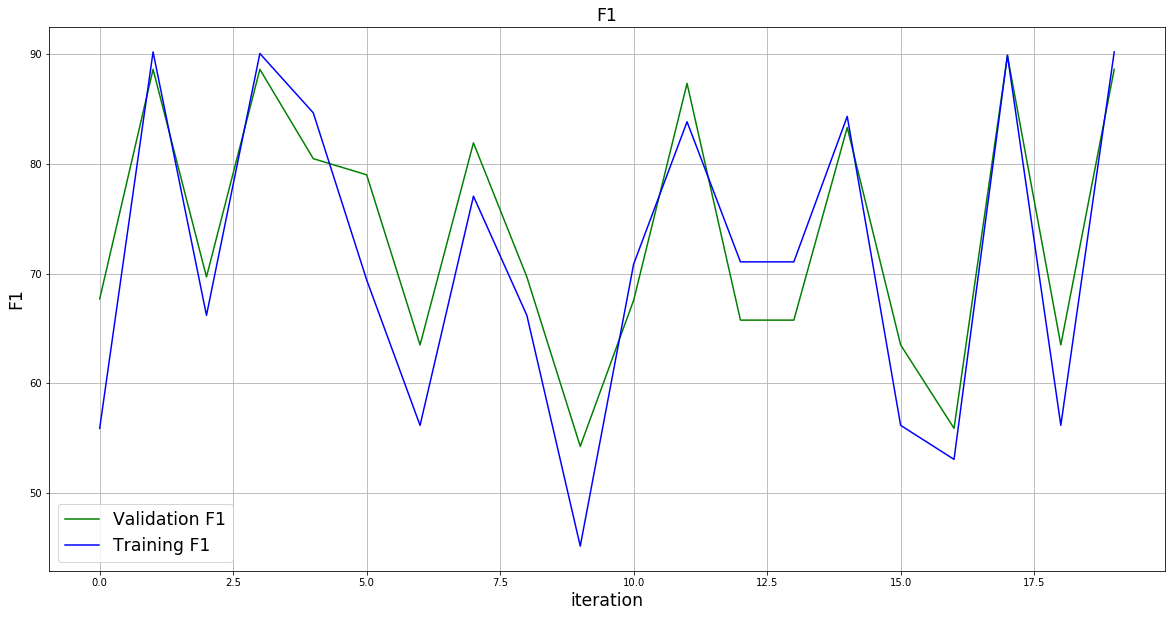

In [72]:
#plt.figure(0)
plt.figure(figsize=(20, 10))
#plt.title('F1 for moh-x dataset on fold ' + str(i))
plt.title('F1', fontsize='xx-large')
plt.xlabel('iteration', fontsize='xx-large')
plt.ylabel('F1', fontsize='xx-large')
plt.plot(val_f1[:20], 'g')
plt.plot(train_f1[:20], 'b')
plt.legend(['Validation F1', 'Training F1'], loc='best', fontsize='xx-large')
plt.grid()
plt.show()

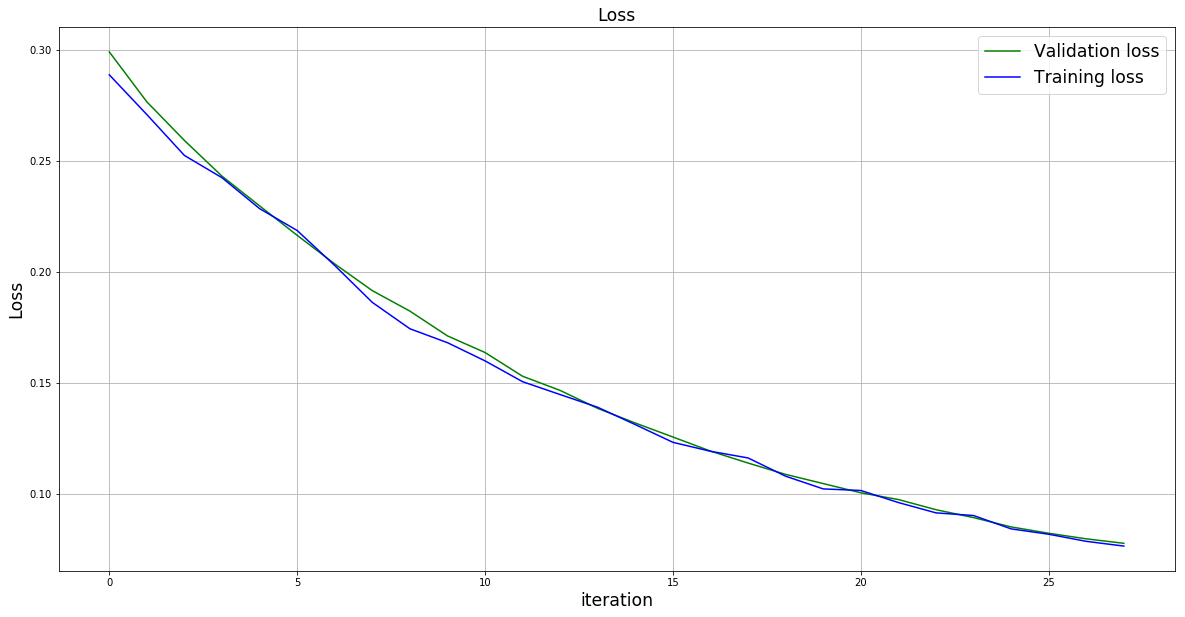

In [73]:
#plt.figure(1)
plt.figure(figsize=(20, 10))
#plt.title('Loss for moh-x dataset on fold ' + str(i))
plt.title('Loss', fontsize='xx-large')
plt.xlabel('iteration', fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large')
plt.plot(val_loss, 'g')
plt.plot(train_loss, 'b')
plt.legend(['Validation loss', 'Training loss'], loc='best', fontsize='xx-large')
plt.grid()
plt.show()

Лучшие f1:

In [74]:
print('val_f1: ', val_f1)
idx = 0
if math.isnan(max(val_f1)):
    optimal_f1s.append(max(val_f1[6:]))
    idx = val_f1.index(optimal_f1s[-1])
    optimal_ps.append(val_p[idx])
    optimal_rs.append(val_r[idx])
    optimal_accs.append(val_acc[idx])
else:
    optimal_f1s.append(max(val_f1))
    idx = val_f1.index(optimal_f1s[-1])
    optimal_ps.append(val_p[idx])
    optimal_rs.append(val_r[idx])
    optimal_accs.append(val_acc[idx])

val_f1:  [67.6923076923077, 88.63636363636364, 69.6969696969697, 88.63636363636364, 80.48780487804879, 79.01234567901234, 63.49206349206349, 81.9277108433735, 69.6969696969697, 54.23728813559322, 67.56756756756755, 87.35632183908046, 65.75342465753425, 65.75342465753425, 83.33333333333334, 63.49206349206349, 55.88235294117647, 89.8876404494382, 63.49206349206349, 88.63636363636364, 83.33333333333334, 77.5, 49.12280701754386, 67.56756756756755, 80.48780487804879, 43.63636363636363, 77.5, 71.05263157894737]


## Результаты работы:

In [75]:
#print('F1 on MOH-X by 10-fold = ', optimal_f1s)
print('Precision  = ', np.mean(np.array(optimal_ps)))
print('Recall  = ', np.mean(np.array(optimal_rs)))
print('F1  = ', np.mean(np.array(optimal_f1s)))
print('Accuracy  = ', np.mean(np.array(optimal_accs)))

Precision  =  86.95652173913044
Recall  =  93.02325581395348
F1  =  89.8876404494382
Accuracy  =  88.60759493670886


In [19]:
#plt.figure(2)
#plt.title('F1 for mohx dataset on ten folds')
#plt.xlabel('fold')
#plt.ylabel('F1')
#plt.plot(optimal_ps,'r')
#plt.plot(optimal_rs,'b')
#plt.plot(optimal_f1s,'g')
#plt.plot(optimal_accs,'c')
#plt.plot([np.mean(np.array(optimal_f1s))] * 10, 'y')
#plt.legend(['precision for each fold', 'recall for each fold', 'F1 for each fold', 'accuracy for each fold', 'Average F1'], loc='upper right')
#plt.show()